In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import  imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.3)
train_dataset=train_datagen.flow_from_directory(directory='E:/data/train/',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True,
                                                batch_size=64)
validation_dataset=train_datagen.flow_from_directory(directory='E:/data/train/',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='validation',
                                                shuffle=True,
                                                batch_size=64)

test_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_dataset=test_datagen.flow_from_directory(directory='E:/data/test/',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True,
                                                batch_size=64)

Found 7000 images belonging to 20 classes.
Found 3000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


In [3]:
IMG_SHAPE = (160, 160, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [4]:
for layer in base_model.layers:
  layer.trainable=False

for i,layer in enumerate(base_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 Conv1 - False
2 bn_Conv1 - False
3 Conv1_relu - False
4 expanded_conv_depthwise - False
5 expanded_conv_depthwise_BN - False
6 expanded_conv_depthwise_relu - False
7 expanded_conv_project - False
8 expanded_conv_project_BN - False
9 block_1_expand - False
10 block_1_expand_BN - False
11 block_1_expand_relu - False
12 block_1_pad - False
13 block_1_depthwise - False
14 block_1_depthwise_BN - False
15 block_1_depthwise_relu - False
16 block_1_project - False
17 block_1_project_BN - False
18 block_2_expand - False
19 block_2_expand_BN - False
20 block_2_expand_relu - False
21 block_2_depthwise - False
22 block_2_depthwise_BN - False
23 block_2_depthwise_relu - False
24 block_2_project - False
25 block_2_project_BN - False
26 block_2_add - False
27 block_3_expand - False
28 block_3_expand_BN - False
29 block_3_expand_relu - False
30 block_3_pad - False
31 block_3_depthwise - False
32 block_3_depthwise_BN - False
33 block_3_depthwise_relu - False
34 block_3_project - Fal

In [5]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(20, activation='softmax')

In [6]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [7]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',keras.metrics.Recall(name='recall'),keras.metrics.Precision(name='precision'),f1_score, keras.metrics.AUC(name='auc')])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
validation_steps=150
initial_epochs = 150

In [10]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    filepath='E:/data/mobilenetv2.hdf5',
    save_best_only=True,
    mode='max',
    verbose=1
    )

In [11]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,verbose=1,callbacks=[model_checkpoint_callback],shuffle=True)

Epoch 1/150


C:\Users\SAPTARSHI PANI\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


110/110 [==============================] - ETA: 0s - loss: 2.6331 - accuracy: 0.2114 - recall: 0.0041 - precision: 0.6304 - f1_score: 0.0080 - auc: 0.7370
Epoch 1: val_accuracy improved from -inf to 0.35967, saving model to E:/data\mobilenetv2.hdf5
110/110 [==============================] - 153s 1s/step - loss: 2.6331 - accuracy: 0.2114 - recall: 0.0041 - precision: 0.6304 - f1_score: 0.0080 - auc: 0.7370 - val_loss: 2.1384 - val_accuracy: 0.3597 - val_recall: 0.0187 - val_precision: 0.7887 - val_f1_score: 0.0359 - val_auc: 0.8764
Epoch 2/150
110/110 [==============================] - ETA: 0s - loss: 1.6786 - accuracy: 0.5294 - recall: 0.0790 - precision: 0.9021 - f1_score: 0.1415 - auc: 0.9486
Epoch 2: val_accuracy improved from 0.35967 to 0.54800, saving model to E:/data\mobilenetv2.hdf5
110/110 [==============================] - 60s 543ms/step - loss: 1.6786 - accuracy: 0.5294 - recall: 0.0790 - precision: 0.9021 - f1_score: 0.1415 - auc: 0.9486 - val_loss: 1.5482 - val_accuracy: 0.

Epoch 16/150
110/110 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.9203 - recall: 0.8450 - precision: 0.9573 - f1_score: 0.8966 - auc: 0.9985
Epoch 16: val_accuracy improved from 0.80800 to 0.81033, saving model to E:/data\mobilenetv2.hdf5
110/110 [==============================] - 65s 594ms/step - loss: 0.3505 - accuracy: 0.9203 - recall: 0.8450 - precision: 0.9573 - f1_score: 0.8966 - auc: 0.9985 - val_loss: 0.5609 - val_accuracy: 0.8103 - val_recall: 0.7013 - val_precision: 0.8904 - val_f1_score: 0.7839 - val_auc: 0.9933
Epoch 17/150
110/110 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.9277 - recall: 0.8571 - precision: 0.9597 - f1_score: 0.9050 - auc: 0.9987
Epoch 17: val_accuracy improved from 0.81033 to 0.81500, saving model to E:/data\mobilenetv2.hdf5
110/110 [==============================] - 63s 577ms/step - loss: 0.3347 - accuracy: 0.9277 - recall: 0.8571 - precision: 0.9597 - f1_score: 0.9050 - auc: 0.9987 - val_loss: 0.54

110/110 [==============================] - 65s 597ms/step - loss: 0.2081 - accuracy: 0.9593 - recall: 0.9347 - precision: 0.9722 - f1_score: 0.9532 - auc: 0.9996 - val_loss: 0.4350 - val_accuracy: 0.8430 - val_recall: 0.7877 - val_precision: 0.8971 - val_f1_score: 0.8386 - val_auc: 0.9954
Epoch 32/150
110/110 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9597 - recall: 0.9366 - precision: 0.9733 - f1_score: 0.9543 - auc: 0.9996
Epoch 32: val_accuracy did not improve from 0.84500
110/110 [==============================] - 70s 636ms/step - loss: 0.2024 - accuracy: 0.9597 - recall: 0.9366 - precision: 0.9733 - f1_score: 0.9543 - auc: 0.9996 - val_loss: 0.4259 - val_accuracy: 0.8443 - val_recall: 0.7910 - val_precision: 0.8958 - val_f1_score: 0.8396 - val_auc: 0.9956
Epoch 33/150
110/110 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9607 - recall: 0.9400 - precision: 0.9732 - f1_score: 0.9563 - auc: 0.9996
Epoch 33: val_accuracy improved 

Epoch 47/150
110/110 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9747 - recall: 0.9634 - precision: 0.9840 - f1_score: 0.9733 - auc: 0.9998
Epoch 47: val_accuracy did not improve from 0.86400
110/110 [==============================] - 67s 611ms/step - loss: 0.1423 - accuracy: 0.9747 - recall: 0.9634 - precision: 0.9840 - f1_score: 0.9733 - auc: 0.9998 - val_loss: 0.3717 - val_accuracy: 0.8620 - val_recall: 0.8217 - val_precision: 0.8996 - val_f1_score: 0.8588 - val_auc: 0.9964
Epoch 48/150
110/110 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.9743 - recall: 0.9641 - precision: 0.9830 - f1_score: 0.9733 - auc: 0.9999
Epoch 48: val_accuracy did not improve from 0.86400
110/110 [==============================] - 66s 600ms/step - loss: 0.1396 - accuracy: 0.9743 - recall: 0.9641 - precision: 0.9830 - f1_score: 0.9733 - auc: 0.9999 - val_loss: 0.3688 - val_accuracy: 0.8617 - val_recall: 0.8227 - val_precision: 0.9014 - val_f1_score: 0.860

Epoch 63/150
110/110 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9841 - recall: 0.9776 - precision: 0.9892 - f1_score: 0.9834 - auc: 0.9999
Epoch 63: val_accuracy did not improve from 0.87667
110/110 [==============================] - 64s 584ms/step - loss: 0.1045 - accuracy: 0.9841 - recall: 0.9776 - precision: 0.9892 - f1_score: 0.9834 - auc: 0.9999 - val_loss: 0.3379 - val_accuracy: 0.8733 - val_recall: 0.8437 - val_precision: 0.9039 - val_f1_score: 0.8726 - val_auc: 0.9969
Epoch 64/150
110/110 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9847 - recall: 0.9780 - precision: 0.9902 - f1_score: 0.9841 - auc: 0.9999
Epoch 64: val_accuracy did not improve from 0.87667
110/110 [==============================] - 65s 593ms/step - loss: 0.1029 - accuracy: 0.9847 - recall: 0.9780 - precision: 0.9902 - f1_score: 0.9841 - auc: 0.9999 - val_loss: 0.3415 - val_accuracy: 0.8747 - val_recall: 0.8440 - val_precision: 0.9020 - val_f1_score: 0.871

Epoch 79/150
110/110 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9903 - recall: 0.9863 - precision: 0.9934 - f1_score: 0.9898 - auc: 1.0000
Epoch 79: val_accuracy did not improve from 0.88067
110/110 [==============================] - 74s 672ms/step - loss: 0.0802 - accuracy: 0.9903 - recall: 0.9863 - precision: 0.9934 - f1_score: 0.9898 - auc: 1.0000 - val_loss: 0.3209 - val_accuracy: 0.8793 - val_recall: 0.8543 - val_precision: 0.9034 - val_f1_score: 0.8778 - val_auc: 0.9970
Epoch 80/150
110/110 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9907 - recall: 0.9870 - precision: 0.9930 - f1_score: 0.9900 - auc: 1.0000
Epoch 80: val_accuracy improved from 0.88067 to 0.88100, saving model to E:/data\mobilenetv2.hdf5
110/110 [==============================] - 72s 655ms/step - loss: 0.0788 - accuracy: 0.9907 - recall: 0.9870 - precision: 0.9930 - f1_score: 0.9900 - auc: 1.0000 - val_loss: 0.3151 - val_accuracy: 0.8810 - val_recall: 0.8567

Epoch 95/150
110/110 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9944 - recall: 0.9917 - precision: 0.9961 - f1_score: 0.9939 - auc: 1.0000
Epoch 95: val_accuracy did not improve from 0.88400
110/110 [==============================] - 67s 608ms/step - loss: 0.0629 - accuracy: 0.9944 - recall: 0.9917 - precision: 0.9961 - f1_score: 0.9939 - auc: 1.0000 - val_loss: 0.3079 - val_accuracy: 0.8827 - val_recall: 0.8613 - val_precision: 0.9019 - val_f1_score: 0.8810 - val_auc: 0.9970
Epoch 96/150
110/110 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9949 - recall: 0.9927 - precision: 0.9967 - f1_score: 0.9947 - auc: 1.0000
Epoch 96: val_accuracy did not improve from 0.88400
110/110 [==============================] - 66s 605ms/step - loss: 0.0622 - accuracy: 0.9949 - recall: 0.9927 - precision: 0.9967 - f1_score: 0.9947 - auc: 1.0000 - val_loss: 0.3034 - val_accuracy: 0.8840 - val_recall: 0.8647 - val_precision: 0.9045 - val_f1_score: 0.883

Epoch 111/150
110/110 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9969 - recall: 0.9946 - precision: 0.9976 - f1_score: 0.9961 - auc: 1.0000
Epoch 111: val_accuracy did not improve from 0.88767
110/110 [==============================] - 67s 610ms/step - loss: 0.0509 - accuracy: 0.9969 - recall: 0.9946 - precision: 0.9976 - f1_score: 0.9961 - auc: 1.0000 - val_loss: 0.2987 - val_accuracy: 0.8833 - val_recall: 0.8697 - val_precision: 0.9018 - val_f1_score: 0.8853 - val_auc: 0.9971
Epoch 112/150
110/110 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9966 - recall: 0.9947 - precision: 0.9976 - f1_score: 0.9961 - auc: 1.0000
Epoch 112: val_accuracy did not improve from 0.88767
110/110 [==============================] - 66s 602ms/step - loss: 0.0502 - accuracy: 0.9966 - recall: 0.9947 - precision: 0.9976 - f1_score: 0.9961 - auc: 1.0000 - val_loss: 0.3006 - val_accuracy: 0.8847 - val_recall: 0.8693 - val_precision: 0.9021 - val_f1_score: 0

Epoch 127/150
110/110 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9980 - recall: 0.9966 - precision: 0.9987 - f1_score: 0.9974 - auc: 1.0000
Epoch 127: val_accuracy did not improve from 0.89000
110/110 [==============================] - 66s 599ms/step - loss: 0.0416 - accuracy: 0.9980 - recall: 0.9966 - precision: 0.9987 - f1_score: 0.9974 - auc: 1.0000 - val_loss: 0.2943 - val_accuracy: 0.8863 - val_recall: 0.8740 - val_precision: 0.9017 - val_f1_score: 0.8875 - val_auc: 0.9967
Epoch 128/150
110/110 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9983 - recall: 0.9971 - precision: 0.9987 - f1_score: 0.9979 - auc: 1.0000
Epoch 128: val_accuracy did not improve from 0.89000
110/110 [==============================] - 65s 589ms/step - loss: 0.0412 - accuracy: 0.9983 - recall: 0.9971 - precision: 0.9987 - f1_score: 0.9979 - auc: 1.0000 - val_loss: 0.2957 - val_accuracy: 0.8883 - val_recall: 0.8747 - val_precision: 0.9039 - val_f1_score: 0

Epoch 143/150
110/110 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9986 - recall: 0.9981 - precision: 0.9990 - f1_score: 0.9986 - auc: 1.0000
Epoch 143: val_accuracy did not improve from 0.89100
110/110 [==============================] - 65s 589ms/step - loss: 0.0343 - accuracy: 0.9986 - recall: 0.9981 - precision: 0.9990 - f1_score: 0.9986 - auc: 1.0000 - val_loss: 0.2945 - val_accuracy: 0.8867 - val_recall: 0.8760 - val_precision: 0.8997 - val_f1_score: 0.8875 - val_auc: 0.9966
Epoch 144/150
110/110 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9990 - recall: 0.9983 - precision: 0.9991 - f1_score: 0.9987 - auc: 1.0000
Epoch 144: val_accuracy did not improve from 0.89100
110/110 [==============================] - 63s 574ms/step - loss: 0.0340 - accuracy: 0.9990 - recall: 0.9983 - precision: 0.9991 - f1_score: 0.9987 - auc: 1.0000 - val_loss: 0.2910 - val_accuracy: 0.8880 - val_recall: 0.8740 - val_precision: 0.9007 - val_f1_score: 0

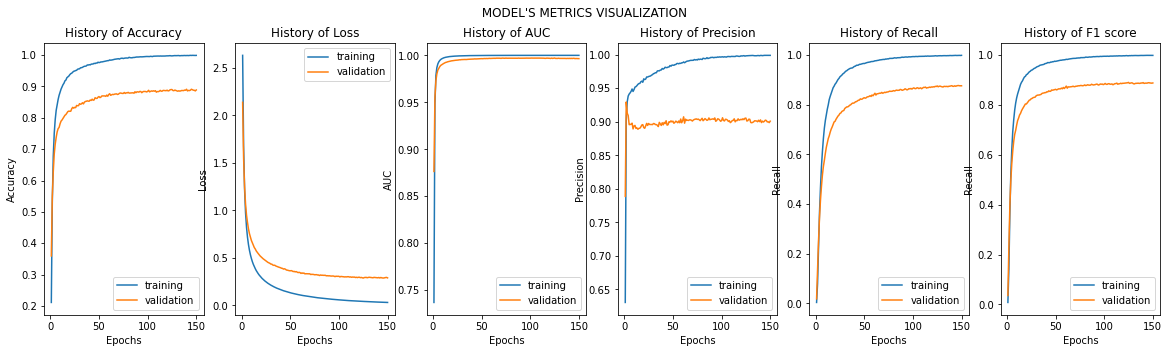

In [13]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,f1_score,val_f1_score):
    
    fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])

    ax6.plot(range(1, len(f1_score) + 1), f1_score)
    ax6.plot(range(1, len(val_f1_score) + 1), val_f1_score)
    ax6.set_title('History of F1 score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('Recall')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['recall'],history.history['val_recall'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [14]:
model.save("E:/data/mobilenetv2.hdf5")

name_last_layer = str(model.layers[-1])
name_seclast_layer = str(model.layers[-2])

model2 = keras.Sequential()
for layer in model.layers:
    if str(layer) != name_last_layer:
        if str(layer) != name_seclast_layer:
            model2.add(layer)
        
model2.summary()    

model2.save('E:/data/mobilenetv2_mod.hdf5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
model = keras.models.load_model("E:/data/mobilenetv2.hdf5", custom_objects={"f1_score": f1_score })
model.evaluate(test_dataset)

32/32 [==============================] - 40s 1s/step - loss: 0.3986 - accuracy: 0.8570 - recall: 0.8460 - precision: 0.8686 - f1_score: 0.8559 - auc: 0.9919


[0.3985903859138489,
 0.8569999933242798,
 0.8460000157356262,
 0.8685831427574158,
 0.8559393286705017,
 0.9918657541275024]

C:\Users\SAPTARSHI PANI\AppData\Local\Temp\ipykernel_21532\3963585414.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)


Confusion Matrix


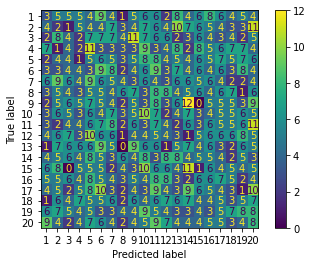

Classification Report
              precision    recall  f1-score   support

           1       0.04      0.03      0.03       100
           2       0.02      0.02      0.02       100
           3       0.05      0.04      0.04       100
           4       0.03      0.02      0.02       100
           5       0.04      0.05      0.04       100
           6       0.08      0.09      0.08       100
           7       0.05      0.05      0.05       100
           8       0.11      0.06      0.08       100
           9       0.05      0.05      0.05       100
          10       0.08      0.10      0.09       100
          11       0.05      0.07      0.06       100
          12       0.04      0.04      0.04       100
          13       0.05      0.05      0.05       100
          14       0.04      0.04      0.04       100
          15       0.01      0.01      0.01       100
          16       0.06      0.06      0.06       100
          17       0.04      0.04      0.04       100
     

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))